In [32]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
# from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, BatchNormalization,Dropout, Conv2D,LeakyReLU, GlobalAveragePooling2D,InputLayer

In [ ]:
from ultralytics import YOLO
import cv2

# --- Load YOLO model once outside the function ---
yolo_model = YOLO(r"C:\Users\Dell\Desktop\yolo_models\runs\detect\train4\weights\best.pt")

def detect_plate(img, text=''):
    plate_img = img.copy()
    roi = img.copy()

    # --- Run YOLO prediction on the input image ---
    results = yolo_model.predict(source=img, conf=0.25, save=False, verbose=False)

    # --- Collect bounding boxes from YOLO output ---
    plate_rect = []  
    for r in results:
        for box in r.boxes.xyxy:  # xyxy for this type of format: [x1, y1, x2, y2] 
            x1, y1, x2, y2 = box.cpu().numpy().astype(int)
            w, h = x2 - x1, y2 - y1
            plate_rect.append((x1, y1, w, h))

    for (x, y, w, h) in plate_rect:
        roi_ = roi[y:y+h, x:x+w, :]
        plate = roi[y:y+h, x:x+w, :]
        cv2.rectangle(plate_img, (x+2, y), (x+w-3, y+h-5), (51, 181, 155), 2)

    if text != '':
        plate_img = cv2.putText(plate_img, text, (x - w//2, y - h//2),
                                cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.5, (51, 181, 155), 1, cv2.LINE_AA)

    return plate_img, plate


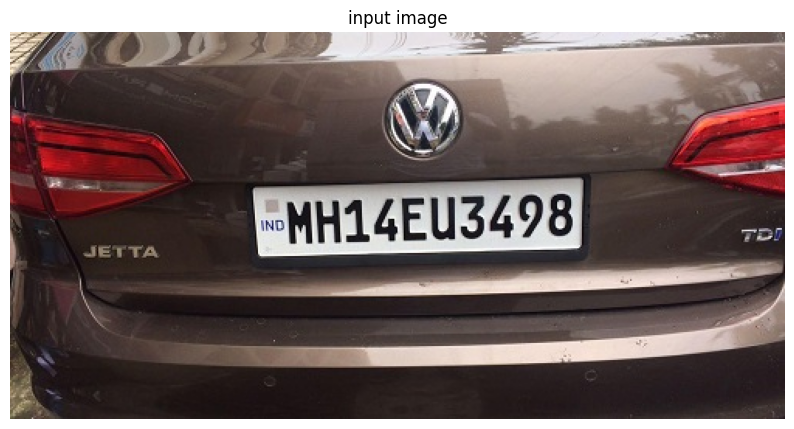

In [ ]:
# Testing the above function
def display(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

img = cv2.imread(r'C:\Users\Dell\Desktop\yolo_models\train\images\2adfb5e7-e70a-4749-b5fa-8c233c0d47d9___new_1572920d1478091901-your-favourite-number-plate-font-jetta-german-font.jpg.jpeg')
display(img, 'input image')

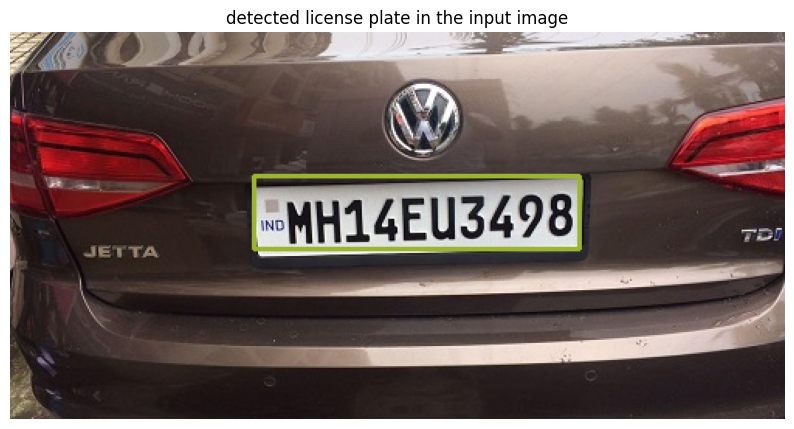

In [35]:
# Getting plate prom the processed image
output_img, plate = detect_plate(img)
display(output_img, 'detected license plate in the input image')

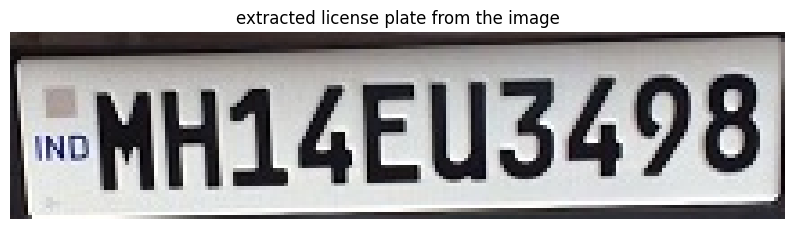

In [36]:
display(plate, 'extracted license plate from the image')

In [37]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [38]:
# #Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

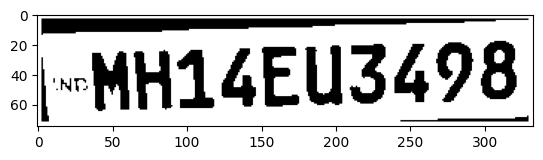

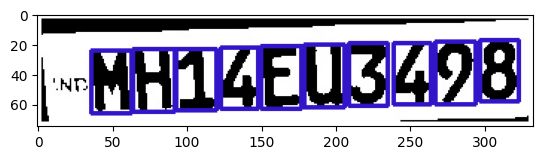

In [39]:
# Let's see the segmented characters
char = segment_characters(plate)

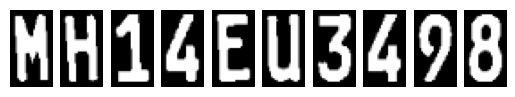

In [40]:
for i in range(len(char)):
    plt.subplot(1, len(char), i + 1)
    plt.imshow(char[i],cmap='gray')
    plt.axis('off')

# Model for characters

## trial model to get the some estimate about parameters

In [ ]:
path = r'C:\Users\Dell\Desktop\yolo_models\data\data'

train_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

train_generator = train_datagen.flow_from_directory(
    directory=path + "/train",   
    target_size=(28, 28),        
    batch_size=1,               
    class_mode='sparse'          
)

validation_generator = train_datagen.flow_from_directory(
    directory=path + "/val",     
    target_size=(28, 28),        
    batch_size=1,                
    class_mode='sparse'
)

model = Sequential()

# --- Block 1 ---
model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(28,28,3)))
model.add(BatchNormalization())

# --- Block 2 ---
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())

# --- Block 3 ---
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# --- Transition ---
model.add(GlobalAveragePooling2D())

# --- Fully Connected Layers ---
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# --- Output Layer ---
model.add(Dense(36, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [31]:
es = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True)

re_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=80,
                    verbose=1,
                    callbacks=es)

Epoch 1/80
864/864 ━━━━━━━━━━━━━━━━━━━━ 29s 28ms/step - accuracy: 0.0150 - loss: 3.5938 - val_accuracy: 0.0509 - val_loss: 8.7517
Epoch 2/80
864/864 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.0220 - loss: 3.5931 - val_accuracy: 0.0185 - val_loss: 10.1165
Epoch 3/80
864/864 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.0220 - loss: 3.5943 - val_accuracy: 0.0231 - val_loss: 9.6487
Epoch 4/80
864/864 ━━━━━━━━━━━━━━━━━━━━ 27s 31ms/step - accuracy: 0.0162 - loss: 3.5947 - val_accuracy: 0.0185 - val_loss: 9.6280
Epoch 5/80
864/864 ━━━━━━━━━━━━━━━━━━━━ 28s 32ms/step - accuracy: 0.0174 - loss: 3.5935 - val_accuracy: 0.0417 - val_loss: 10.3758
Epoch 6/80
864/864 ━━━━━━━━━━━━━━━━━━━━ 30s 35ms/step - accuracy: 0.0255 - loss: 3.5947 - val_accuracy: 0.0370 - val_loss: 10.6162
Epoch 7/80
864/864 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.0208 - loss: 3.5936 - val_accuracy: 0.0231 - val_loss: 9.7772
Epoch 8/80
864/864 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.0150 - loss: 3.5948

## working for the prediction

In [ ]:
import cv2
img = cv2.imread(r'C:\Users\Dell\Desktop\yolo_models\data\data\train\class_M\class_M_2.jpg')

re_img=cv2.resize(img,(28,28))
cv2.imshow("Original", img)
cv2.imshow("Resized", re_img)

# Wait for a key press and close windows
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
# Predicting the output
def fix_dimension(img): 
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_pred = model.predict(img)
        y_index = np.argmax(y_pred, axis=1)[0]  # get class index with highest probability
        
        character = dic[y_index]
        output.append(character)
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
KA04MN3622


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

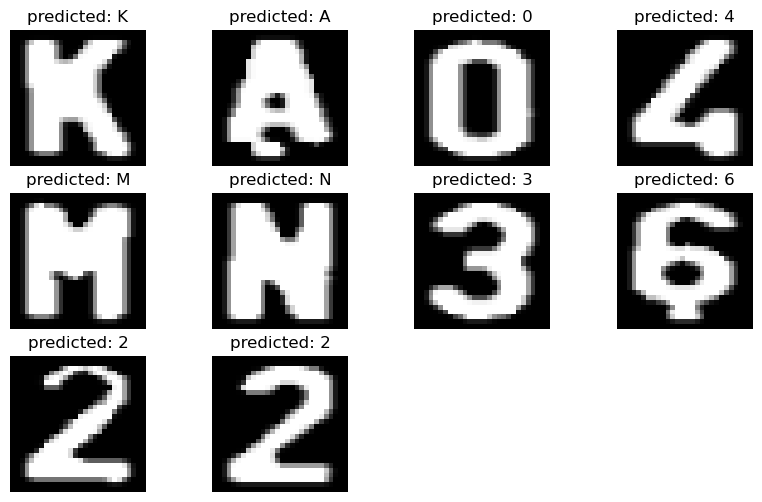

In [ ]:
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()

In [ ]:
# Save the entire model
model.save("license_plate_cnn_model.h5")


NameError: name 'model' is not defined